In [124]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

<br>

## 1. Preparing dataset 

In [125]:
# 데이터 불러오기

data_all = pd.read_csv('titanic.csv', encoding='utf-8')

## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [126]:
# jupyter notebook 내에 figure를 보여주기
from matplotlib import font_manager, rc
%matplotlib inline 

# matplotlib의 한글문제를 해결
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name() # 컴퓨터 안의 폰트 파일을 가져옴.
# 맑은 고딕 외 다른 폰트들도 가능
# font_name
rc('font', family=font_name) # run configuration


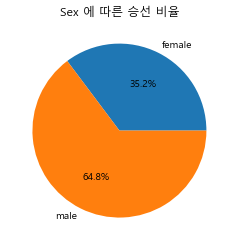

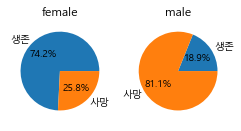

In [127]:
# 데이터 분석
# feature에 따른 사망비율, 생존비율 시각화 


def pie_chart(feature):
    feature_ratio = data_all[feature].value_counts(sort=False)
    feature_size = feature_ratio.size
    feature_index = feature_ratio.index
    survived = data_all[data_all['Survived'] == 1][feature].value_counts()
    dead = data_all[data_all['Survived'] == 0][feature].value_counts()


    plt.plot(aspect='auto')
    plt.pie(feature_ratio, labels=feature_index, autopct='%1.1f%%')
    plt.title(feature + ' 에 따른 승선 비율')
    plt.show()

    for i, index in enumerate(feature_index):
        plt.subplot(1, feature_size + 1, i + 1, aspect='equal')
        plt.pie([survived[index], dead[index]], labels=['생존', '사망'], autopct='%1.1f%%')
        plt.title(str(index))

plt.show()
pie_chart('Sex')

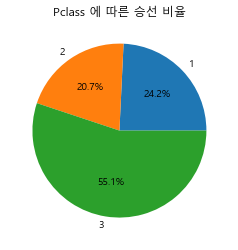

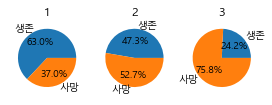

In [128]:
pie_chart('Pclass')

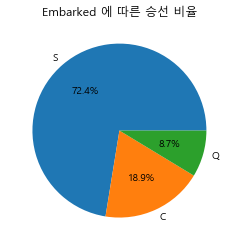

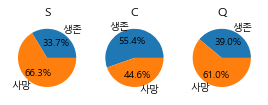

In [129]:
pie_chart('Embarked')

<br>

## 2. Feature engineering & Feature selection

In [130]:
# 필요없는 열 제거

del data_all['PassengerId']
del data_all['Ticket']
del data_all['Cabin']

In [131]:
# Name 열 전처리

data_all['Name']=data_all['Name'].str.extract(' ([A-Za-z]+)\.')

In [132]:
pd.crosstab(data_all['Name'], data_all['Sex'])

Sex,female,male
Name,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [133]:
# 상위 5개 이름 분류 추출

data_all['Name'] = data_all['Name'].replace(['Capt', 'Col', 'Countess', 'Don','Dona', 'Dr', 'Jonkheer',
                                                 'Lady','Major', 'Rev', 'Sir'], 'Other')
data_all['Name'] = data_all['Name'].replace('Mlle', 'Miss')
data_all['Name'] = data_all['Name'].replace('Mme', 'Mrs')
data_all['Name'] = data_all['Name'].replace('Ms', 'Miss')



data_name_sur=data_all[['Name', 'Survived']].groupby(['Name'], as_index=False).mean()
data_name_sur=pd.DataFrame(data_name_sur)
data_name_sur=data_name_sur.sort_values(by='Survived',ascending=False)
data_name_sur

,Name,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,Other,0.347826
2,Mr,0.156673


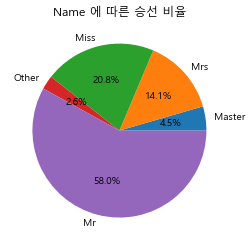

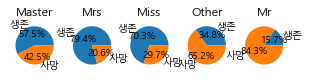

In [134]:
pie_chart('Name')

In [135]:
# 숫자로 변환

for i, item in enumerate(data_all['Name']):
    if item is data_name_sur['Name'][0]:
        data_all['Name'][i] = 3
    elif item is data_name_sur['Name'][1]:
        data_all['Name'][i] = 4
    elif item is data_name_sur['Name'][2]:
        data_all['Name'][i] = 1
    elif item is data_name_sur['Name'][3]:
        data_all['Name'][i] = 5
    else:
        data_all['Name'][i] = 2

In [136]:
# x_data, y_data 분류

y_data = data_all['Survived']
del data_all['Survived']

x_data= data_all.copy()

In [137]:
# Sex 열 전처리

x_data = x_data.replace(['male', 'female'], [1, 2])

In [138]:
# Embarked 열 결측치 채우기

x_data["Embarked"] = x_data['Embarked'].replace(['S','C','Q',np.NAN],[1,2,3,1])

In [139]:
# K-means 사용해 Age 열 결측치 채우기


temp = x_data.copy()
del temp['Age']

from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=5, random_state=0).fit(temp)
x_data['Label'] = kmeans.labels_

age_sum = [0.0, 0.0, 0.0, 0.0, 0.0]
age_num = [0.0, 0.0, 0.0, 0.0, 0.0]
for i, label in enumerate(x_data['Label']):
    if math.isnan(x_data['Age'][i]):
        continue
    else:
        age_sum[label] += x_data['Age'][i]
        age_num[label] += 1

# label별 평균 확인
age_mean = [0.0, 0.0, 0.0, 0.0, 0.0]
for i in range(5):
    age_mean[i] = age_sum[i] / age_num[i]

# Age의 결측치 채우기 
for i, label in enumerate(x_data['Label']):
    if math.isnan(x_data['Age'][i]):
        x_data['Age'][i] = age_mean[label]

In [140]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Pclass      891 non-null int64
Name        891 non-null int64
Sex         891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null int64
Label       891 non-null int32
dtypes: float64(2), int32(1), int64(6)
memory usage: 59.2 KB


<br>

## 3. Train - Test split 

In [141]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=0)

In [142]:
from sklearn.preprocessing import StandardScaler  # (sklearn.preprocessing.MinMaxScaler is also available)

sc = StandardScaler()
sc.fit(x_train) # X_train 의 평균과 표준편차를 구함

# As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set).
x_train_scaled = sc.transform(x_train)
x_test_scaled = sc.transform(x_test)

<br>

## 4. Create model instance variable

In [143]:
from sklearn import linear_model
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


In [144]:
# Xgboost

gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=10)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
xgb_random.fit(x_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'n_estimators': 13, 'max_depth': 6, 'learning_rate': 0.45, 'colsample_bytree': 1}
Best accuracy found:  0.8282504012841091


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished


In [145]:
# LogisticRegression 모델 적용

from sklearn import linear_model

model_LM = linear_model.LogisticRegression()

In [146]:
# SVM 모델 적용

from sklearn.svm import SVC

model_SVC = SVC()

In [147]:
# KNN 모델 적용

from matplotlib.colors import ListedColormap
from sklearn import neighbors

model_KNN = neighbors.KNeighborsClassifier()

In [148]:
# GradientBoostingClassifier 모델 적용

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

model_GPC = GradientBoostingClassifier(random_state=0) # 기본값: max_depth=3, learning_rate=0.1

In [149]:
# DesicionTreeClassifier 모델 적용

from sklearn.tree import DecisionTreeClassifier

model_DTC = DecisionTreeClassifier()

In [150]:
# ExtraTreeClassifier 모델 적용

from sklearn.tree import ExtraTreeClassifier

model_ETC = ExtraTreeClassifier(max_depth=3,  min_samples_split=2)

In [151]:
# RandomForestClassifier 모델 적용

from sklearn.ensemble import RandomForestClassifier

model_RFC = RandomForestClassifier()

In [152]:
# AdaBoostClassifier 모델 적용

from sklearn.ensemble import AdaBoostClassifier

model_ABC = AdaBoostClassifier()

In [153]:
#BaggingClassifier 모델 적용

from sklearn.ensemble import BaggingClassifier

model_BC = BaggingClassifier()

<br>

## 5. Train the model

In [154]:
# XGBoost 모델 적용

xgb_random.fit(x_train, y_train)
print("XGBoost 훈련 정확도:", xgb_random.best_score_)


model_LM.fit(x_train, y_train)

score_train = model_LM.score(x_train, y_train) # train set 정확도
print("LogisticRegression 훈련 정확도: {:.3f}".format(score_train))


model_SVC.fit(x_train, y_train)

score_train = model_SVC.score(x_train, y_train) 
print("SVM 훈련 정확도: {:.3f}".format(score_train))


model_KNN.fit(x_train, y_train)

score_train = model_KNN.score(x_train, y_train)
print("KNN 훈련 정확도: {:.3f}".format(score_train))


model_GPC.fit(x_train, y_train)

score_train = model_GPC.score(x_train, y_train) 
print("GradientBoostingClassifier 훈련 정확도: {:.3f}".format(score_train))


model_DTC.fit(x_train, y_train)

score_train = model_DTC.score(x_train, y_train)
print("DesicionTreeClassifier 훈련 정확도: {:.3f}".format(score_train))


model_ETC.fit(x_train, y_train)

score_train = model_ETC.score(x_train, y_train) 
print("ExtraTreeClassifier 훈련 정확도: {:.3f}".format(score_train))


model_RFC.fit(x_train, y_train)

score_train = model_RFC.score(x_train, y_train)
print("RandomForestClassifier 훈련 정확도: {:.3f}".format(score_train))


model_ABC.fit(x_train, y_train)

score_train = model_ABC.score(x_train, y_train)
print("AdaBoostClassifier 훈련 정확도: {:.3f}".format(score_train))


model_BC.fit(x_train, y_train)

score_train = model_BC.score(x_train, y_train)
print("BaggingClassifier 훈련 정확도: {:.3f}".format(score_train))



Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGBoost 훈련 정확도: 0.826645264847512
LogisticRegression 훈련 정확도: 0.799
SVM 훈련 정확도: 0.881
KNN 훈련 정확도: 0.788
GradientBoostingClassifier 훈련 정확도: 0.905
DesicionTreeClassifier 훈련 정확도: 0.979
ExtraTreeClassifier 훈련 정확도: 0.801
RandomForestClassifier 훈련 정확도: 0.958
AdaBoostClassifier 훈련 정확도: 0.838
BaggingClassifier 훈련 정확도: 0.963


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.8s finished


<br>

## 5. Predict on test data & Check the result with metrics (모델 간 비교가 가능합니다.)

In [155]:

xgb_random.fit(x_test, y_test)
print("XGBoost 테스트 정확도:", xgb_random.best_score_)


score_test = model_LM.score(x_test, y_test) # 일반화 정확도
print("LogisticRegression 테스트 정확도: {:.3f}".format(score_test))


score_test = model_SVC.score(x_test, y_test) 
print("SVM 테스트 정확도: {:.3f}".format(score_test))


score_test = model_KNN.score(x_test, y_test) 
print("KNN 테스트 정확도: {:.3f}".format(score_test))


score_test = model_GPC.score(x_test, y_test)
print("GradientBoostingClassifier 테스트 정확도: {:.3f}".format(score_test))


score_test = model_DTC.score(x_test, y_test) 
print("DesicionTreeClassifier 테스트 정확도: {:.3f}".format(score_test))


score_test = model_ETC.score(x_test, y_test) 
print("ExtraTreeClassifier 테스트 정확도: {:.3f}".format(score_test))


score_test = model_RFC.score(x_test, y_test)
print("RandomForestClassifier 테스트 정확도: {:.3f}".format(score_test))


score_test = model_ABC.score(x_test, y_test)
print("AdaBoostClassifier 테스트 정확도: {:.3f}".format(score_test))


score_test = model_BC.score(x_test, y_test)
print("BaggingClassifier 테스트 정확도: {:.3f}".format(score_test))




Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGBoost 테스트 정확도: 0.8283582089552238
LogisticRegression 테스트 정확도: 0.810
SVM 테스트 정확도: 0.713
KNN 테스트 정확도: 0.705
GradientBoostingClassifier 테스트 정확도: 0.836
DesicionTreeClassifier 테스트 정확도: 0.780
ExtraTreeClassifier 테스트 정확도: 0.799
RandomForestClassifier 테스트 정확도: 0.817
AdaBoostClassifier 테스트 정확도: 0.810
BaggingClassifier 테스트 정확도: 0.802


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


In [159]:
from pandas import DataFrame as df


df_model = df(data = {'훈련 정확도': ['0.83', '0.80', '0.88', '0.79',
                         '0.91', '0.98', '0.98', '0.97', '0.84', '0.96'], 
                      '테스트 정확도':['0.83', '0.81', '0.71', '0.71', 
                         '0.84', '0.78', '0.75', '0.80', '0.81', '0.80']}, 
        index = ['XGBoost', 'LogisticRegression', 'SVM', 'KNN', 'GradientBoostingClassifier', 
                 'DesicionTreeClassifier', 'ExtraTreeClassifier', 'RandomForestClassifier', 
                 'AdaBoostClassifier', 'BaggingClassifier'])

df_model = df_model.astype(float) # type error 발생 시 astype 이용
df_model

,훈련 정확도,테스트 정확도
XGBoost,0.83,0.83
LogisticRegression,0.80,0.81
SVM,0.88,0.71
KNN,0.79,0.71
GradientBoostingClassifier,0.91,0.84
DesicionTreeClassifier,0.98,0.78
ExtraTreeClassifier,0.98,0.75
RandomForestClassifier,0.97,0.80
AdaBoostClassifier,0.84,0.81
BaggingClassifier,0.96,0.80


In [114]:
import nltk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc


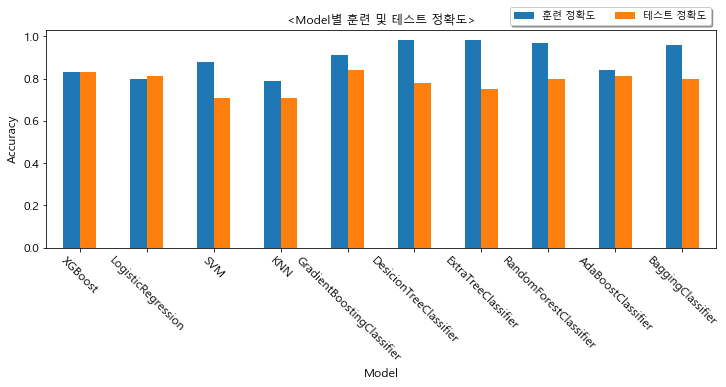

In [115]:
# Windows 한글 폰트 설정
font_name = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name() # NanumGothic.otf
matplotlib.rc('font', family=font_name)
 
# 차트 종류, 제목, 차트 크기, 범례, 폰트 크기 설정
ax = df_model.plot(kind='bar', title='<Model별 훈련 및 테스트 정확도>', figsize=(12, 4), legend=True, fontsize=12)
ax.set_xlabel('Model', fontsize=12)          # x축 정보 표시
ax.set_ylabel('Accuracy', fontsize=12)     # y축 정보 표시
plt.xticks(rotation = - 45 )
#sns.barplot(x="Model", y="Accuracy", data=df_model)
ax.legend(['훈련 정확도', '테스트 정확도'], loc='lower right', fontsize=10, bbox_to_anchor=(1.0, 1.0), ncol=3, shadow=True)    # 범례 지정

In [162]:

df_model2 = df(data = {'훈련 정확도': ['0.83', '0.80', '0.88', '0.79',
                         '0.91', '0.98', '0.80', '0.96', '0.84', '0.96'], 
                      '테스트 정확도':['0.83', '0.81', '0.71', '0.71', 
                         '0.84', '0.78', '0.80', '0.82', '0.81', '0.80']}, 
        index = ['XGBoost', 'LogisticRegression', 'SVM', 'KNN', 'GradientBoostingClassifier', 
                 'DesicionTreeClassifier', 'ExtraTreeClassifier', 'RandomForestClassifier', 
                 'AdaBoostClassifier', 'BaggingClassifier'])

df_model2 = df_model2.astype(float) # type error 발생 시 astype 이용
df_model2

,훈련 정확도,테스트 정확도
XGBoost,0.83,0.83
LogisticRegression,0.80,0.81
SVM,0.88,0.71
KNN,0.79,0.71
GradientBoostingClassifier,0.91,0.84
DesicionTreeClassifier,0.98,0.78
ExtraTreeClassifier,0.80,0.80
RandomForestClassifier,0.96,0.82
AdaBoostClassifier,0.84,0.81
BaggingClassifier,0.96,0.80


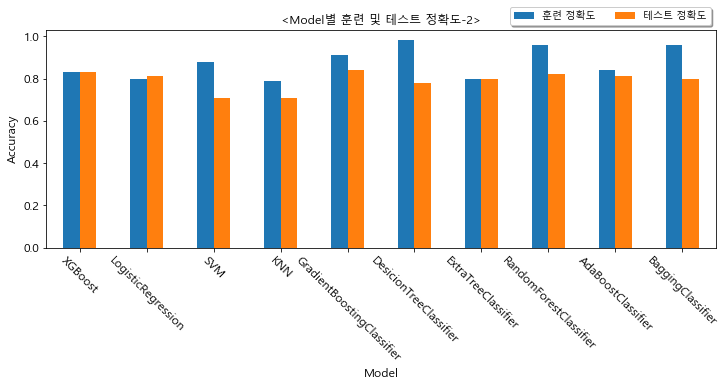

In [163]:
font_name = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name() # NanumGothic.otf
matplotlib.rc('font', family=font_name)

ax = df_model2.plot(kind='bar', title='<Model별 훈련 및 테스트 정확도-2>', figsize=(12, 4), legend=True, fontsize=12)
ax.set_xlabel('Model', fontsize=12)          # x축 정보 표시
ax.set_ylabel('Accuracy', fontsize=12)     # y축 정보 표시
plt.xticks(rotation = - 45 )

ax.legend(['훈련 정확도', '테스트 정확도'], loc='lower right', fontsize=10, bbox_to_anchor=(1.0, 1.0), ncol=3, shadow=True)    # 범례 지정